### 1. Importing Libraries.

In [2]:
import tensorflow as tf 
import tensorflow_hub as hub 
import numpy as np 
from six.moves.urllib.request import urlopen
from six import BytesIO
import tempfile
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont, ImageOps, ImageColor
import time

### 2. Getting the model from `tensorflow_hub` 
* [ssd + mobilenet V2](https://tfhub.dev/tensorflow/ssd_mobilenet_v2/2) small and fast.
* [FasterRCNN + InceptionResNet V2](https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1): high accuracy.

In [3]:
# ssd mobilenet version 2
module_handle = "https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1"

# You can choose inception resnet version 2 instead
#module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"

model  = hub.load(module_handle)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


### 3. Getting the appropriate signature & select the detector(model).  
As some model can be used for different works, there are certain signatures for it. 

In [4]:
print(model.signatures.keys())

KeysView(_SignatureMap({'default': <ConcreteFunction pruned(images) at 0x247E9CAAFA0>}))


In [5]:
detector = model.signatures['default']

### 4. Downloading and resizing the model.

In [6]:
def display_image(image):
    fig = plt.figure(figsize=(20,15))
    plt.grid(False)
    plt.imshow(image)

def image_down_resize(url, new_height=256, new_width=256, display=True):
    # returns (file, filepath)
    _ , filepath = tempfile.mkstemp(suffix=".jpg") 
    response = urlopen(url).read()
    image_data = BytesIO(response)
    pil_image = Image.open(image_data)
    pil_image = ImageOps.fit(image=pil_image, size=(new_height, new_width), method=Image.ANTIALIAS)
    pil_image_rgb = pil_image.convert("RGB")
    pil_image_rgb.save(filepath, format="JPEG")

    if display==True:
        display_image(pil_image)
    return filepath


### 5. Select & load an image.

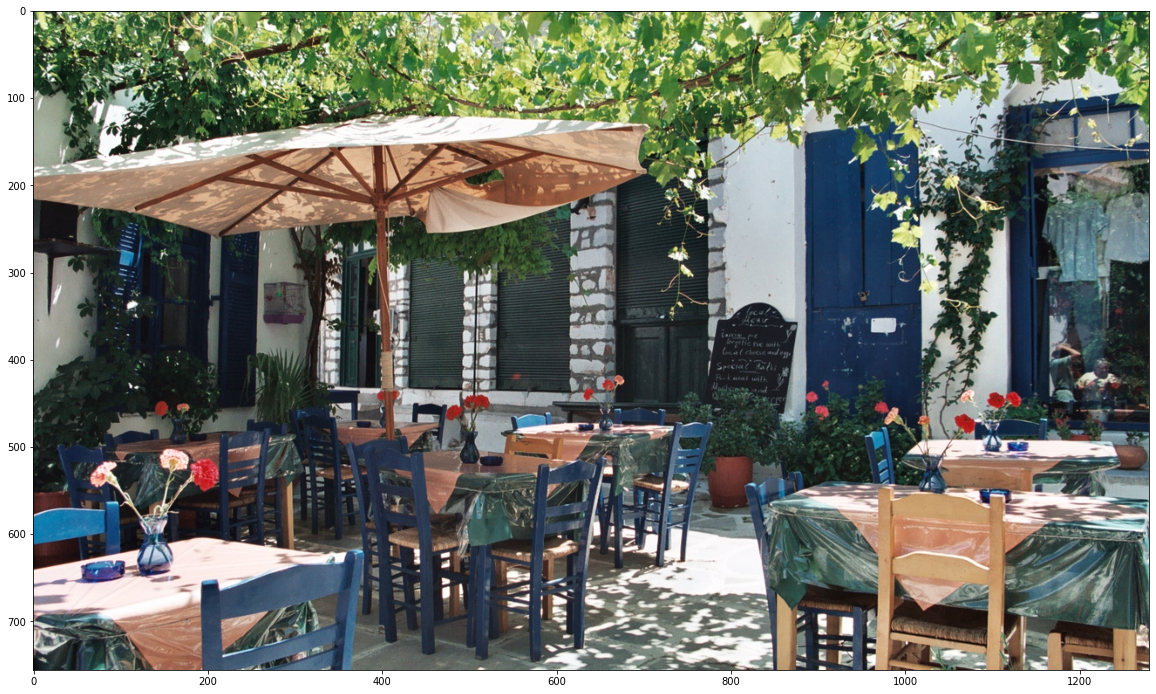

In [7]:
image_url = "https://upload.wikimedia.org/wikipedia/commons/6/60/Naxos_Taverna.jpg" 
downloaded_filepath = image_down_resize(image_url, 1280, 756, display=True)

### 6. Run the detector.

In [20]:
def run_detector(detector, filepath):
    # image is loaded then converted to float type.
    img = tf.io.read_file(filepath)
    image = tf.image.decode_jpeg(img, channels=3)
    converted_img = tf.image.convert_image_dtype(image, tf.float32)[tf.newaxis, ...]
    # converted image is pass through the detector.
    start_time = time.time()
    result = detector(converted_img)
    end_time = time.time()
    result = {key:value.numpy() for key, value in result.items()}

    print(f'Found Objects : {len(result["detection_scores"])}')
    print(f'Time taken : {end_time-start_time}')
    images_with_bbox = draw_bbox(image.numpy(), result['detection_boxes'],  result['detection_class_entities'], result['detection_scores'])
    display_image(images_with_bbox)
    # return image, result

In [21]:
image, result = run_detector(detector, downloaded_filepath)
# scores = result['detection_scores']
# class_entities = result['detection_class_entities']
# bbox = result['detection_boxes']
# class_names = result['detection_class_names']
# class_labels = result['detection_class_labels']

Found Objects : 100
Time taken : 0.3280034065246582


AttributeError: 'numpy.ndarray' object has no attribute 'numpy'

In [139]:
print(scores[0])
print(class_entities[0])
print(bbox[0])
print(class_names[0])
print(class_labels[0])

0.2912632
b'Chair'
[0.64944607 0.37996185 0.9636666  0.515184  ]
b'/m/01mzpv'
97


### 7. Draw Bounding Boxes.

In [15]:
def draw_bbox(image, boxes, class_names, scores, thickness=5, max_boxes=10 , min_score=0.1):
    colors = list(ImageColor.colormap.values())
    font = ImageFont.load_default()
    for i in range(min(boxes.shape[0], max_boxes)):
        if scores[i] >= min_score:
            ymin, xmin, ymax, xmax = tuple(boxes[i])
            display_str = f'{class_names[i].decode("ASCII")} : {int(scores[i]*100)}'
            color = colors[hash(class_names[0])%len(colors)]
            pil_image = Image.fromarray(np.uint8(image)).convert("RGB")

            # creates a ImageDraw object 
            draw = ImageDraw.Draw(pil_image)
            img_width , img_height= pil_image.size

            # scale the bounding box coordinates to the height and width of the image
            (left, right, top, bottom) = (xmin*img_width, xmax*img_width, ymin*img_height, ymax*img_height)
            draw.line([(left,top), (left,bottom), (right,bottom), (right, top), (left,top)], width=thickness, fill=color)

             #If the total height of the display strings added to the top of the bounding
             # # box exceeds the top of the image, stack the strings below the bounding box # instead of above.
            # Each display_str has a top and bottom margin of 0.05x.

            display_str_list = [display_str]
            display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
            total_display_str_height = (1+2*0.05)*sum(display_str_heights) 

            if top >= total_display_str_height:
                text_bottom = top
            else:
                text_bottom = top+total_display_str_height

            # Reverse list and print from bottom to top.


            for display_str in display_str_list[::-1]:
                text_width, text_height = font.getsize(display_str)
                margin = np.ceil(0.05*text_height)
                draw.rectangle([left, text_bottom-text_height-2*margin,(left+text_width, text_bottom)], fill=color)
                draw.text((left+margin, text_bottom-text_height-margin), display_str, fill='black', font=font)
                text_bottom -= text_height - 2*margin

            np.copyto(image, np.array(pil_image))
            
            return image

In [19]:
images_with_bbox = draw_bbox(image.numpy(), result['detection_boxes'],  result['detection_class_entities'], result['detection_scores'])
display_image(images_with_bbox)

AttributeError: 'numpy.ndarray' object has no attribute 'numpy'

<class 'tuple'>
